<a href="https://colab.research.google.com/github/lollcat/fab-torch/blob/master/experiments/many_well/fab_many_well.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flow Annealed Importance Sampling Bootstrap: Many Well Problem
In this notebook we will compare training a flow using FAB with a prioritised buffer, to training a flow by reverse KL divergence minimisation. We will train the models relatively briefly to get indications of how well each method works in a relatively small amount of time, however better results may be obtained by simply increasing the training time. In this notebook we train a flow on a 6 dimensional version of the Many Well problem. The problem difficulty may be increased by increasing the dimension of the Many Well problem.

GPU is not required for this notebook. Each experiment runs on my laptop (CPU only) in under 2 minuates.

# Setup Repo

In [ ]:
!git clone https://github.com/lollcat/fab-torch

In [ ]:
import os
os.chdir("fab-torch")

In [ ]:
!pip install --upgrade .

In [ ]:
# import sys
# sys.path.insert(0, "../")

# Let's go!

## Imports

In [1]:
import normflows as nf
import matplotlib.pyplot as plt
import torch
import numpy as np

from fab import FABModel, HamiltonianMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from fab.target_distributions.many_well import ManyWellEnergy
from fab.utils.prioritised_replay_buffer import PrioritisedReplayBuffer
from fab import Trainer, PrioritisedBufferTrainer
from fab.utils.plotting import plot_contours, plot_marginal_pair


from experiments.make_flow import make_wrapped_normflow_realnvp

/home/laurence/miniconda3/envs/fab-torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup Target distribution

In [2]:
dim = 6 # Can increase in to higher values that are multiples of two.
seed = 0

In [3]:
torch.manual_seed(0)  # seed of 0 for GMM problem
target = ManyWellEnergy(dim, a=-0.5, b=-6, use_gpu=True)

/home/laurence/miniconda3/envs/fab-torch/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


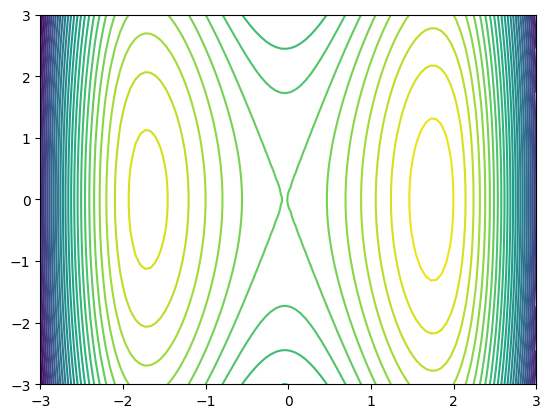

In [4]:
# plot the contours for the marginal distribution of the first 2D of target (i.e. the Double Well Problem). 
target.to("cpu")
fig, ax = plt.subplots()
plotting_bounds = (-3, 3)
plot_contours(target.log_prob_2D, bounds=plotting_bounds, n_contour_levels=40, ax=ax, grid_width_n_points=100)
if torch.cuda.is_available():
    target.to("cuda")

## Create FAB model

In [5]:
# hyper-parameters

# Flow
n_flow_layers = 10
layer_nodes_per_dim = 40
lr = 2e-4
max_gradient_norm = 100.0
batch_size = 128
n_iterations = 500
n_eval = 10
eval_batch_size = batch_size * 10
n_plots = 10 # number of plots shows throughout tranining
use_64_bit = True
alpha = 2.0

# AIS
transition_operator_type = "hmc"
n_intermediate_distributions = 1

# buffer config
n_batches_buffer_sampling = 4
maximum_buffer_length = batch_size* 100
min_buffer_length = batch_size * 10

# target p^\alpha q^{a-\alpha} as target for AIS. 
min_is_target = True
p_target = not min_is_target # Whether to use p as the target. 

In [6]:
if use_64_bit:
    torch.set_default_dtype(torch.float64)
    target = target.double()
    print(f"running with 64 bit")

running with 64 bit


### Setup flow

In [7]:
flow = make_wrapped_normflow_realnvp(dim, n_flow_layers=n_flow_layers, 
                                 layer_nodes_per_dim=layer_nodes_per_dim,
                                act_norm = False)

/home/laurence/miniconda3/envs/fab-torch/lib/python3.9/site-packages/normflows/flows/mixing.py:152: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2349.)
  Q = torch.qr(torch.randn(self.num_channels, self.num_channels))[0]
/home/laurence/miniconda3/envs/fab-torch/lib/python3.9/site-packages/torch/_tensor.py:662: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with


### Setup Transition operator

In [8]:
if transition_operator_type == "hmc":
    # very lightweight HMC.
    transition_operator = HamiltonianMonteCarlo(
            n_ais_intermediate_distributions=n_intermediate_distributions,
            dim=dim,
            base_log_prob=flow.log_prob,
            target_log_prob=target.log_prob,
            alpha=alpha,
            p_target=p_target,
            n_outer=1,
            epsilon=1.0, 
            L=5)
elif transition_operator_type == "metropolis":
    transition_operator = Metropolis(            
        n_ais_intermediate_distributions=n_intermediate_distributions,
        dim=dim,
        base_log_prob=flow.log_prob,
        target_log_prob=target.log_prob,
        alpha=alpha,
        p_target=p_target,
        n_updates=1,
        adjust_step_size=False,
        max_step_size=metropolis_step_size, # the same for all metropolis steps 
        min_step_size=metropolis_step_size,
        eval_mode=False,
                                  )
else:
    raise NotImplementedError

### Setup FAB model with prioritised replay buffer

In [9]:
# use GPU if available
if torch.cuda.is_available():
    flow.cuda()
    transition_operator.cuda()
    print(f"Running with GPU")

In [10]:
fab_model = FABModel(flow=flow,
                     target_distribution=target,
                     n_intermediate_distributions=n_intermediate_distributions,
                     transition_operator=transition_operator,
                     alpha=alpha
                    )
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
logger = ListLogger(save=False) # save training history

In [11]:
# Setup buffer.
def initial_sampler():
  # fill replay buffer using initialised model and AIS.
    point, log_w = fab_model.annealed_importance_sampler.sample_and_log_weights(
            batch_size, logging=False)
    return point.x, log_w, point.log_q
buffer = PrioritisedReplayBuffer(dim=dim, max_length=maximum_buffer_length,
                      min_sample_length=min_buffer_length,
                      initial_sampler=initial_sampler)

In [12]:
def plot(fab_model, n_samples = batch_size, dim=dim):
    n_rows = dim // 2
    fig, axs = plt.subplots(dim // 2, 2,  sharex=True, sharey=True, figsize=(10, n_rows*3))


    samples_flow = fab_model.flow.sample((n_samples,))
    samples_ais = fab_model.annealed_importance_sampler.sample_and_log_weights(n_samples,
                                                                               logging=False)[0].x

    for i in range(n_rows):
        plot_contours(target.log_prob_2D, bounds=plotting_bounds, ax=axs[i, 0], n_contour_levels=40)
        plot_contours(target.log_prob_2D, bounds=plotting_bounds, ax=axs[i, 1], n_contour_levels=40)

        # plot flow samples
        plot_marginal_pair(samples_flow, ax=axs[i, 0], bounds=plotting_bounds, marginal_dims=(i*2,i*2+1))
        axs[i, 0].set_xlabel(f"dim {i*2}")
        axs[i, 0].set_ylabel(f"dim {i*2 + 1}")



        # plot ais samples
        plot_marginal_pair(samples_ais, ax=axs[i, 1], bounds=plotting_bounds, marginal_dims=(i*2,i*2+1))
        axs[i, 1].set_xlabel(f"dim {i*2}")
        axs[i, 1].set_ylabel(f"dim {i*2+1}")
        plt.tight_layout()
    axs[0, 1].set_title("ais samples")  
    axs[0, 0].set_title("flow samples")
    plt.show()
    return [fig]

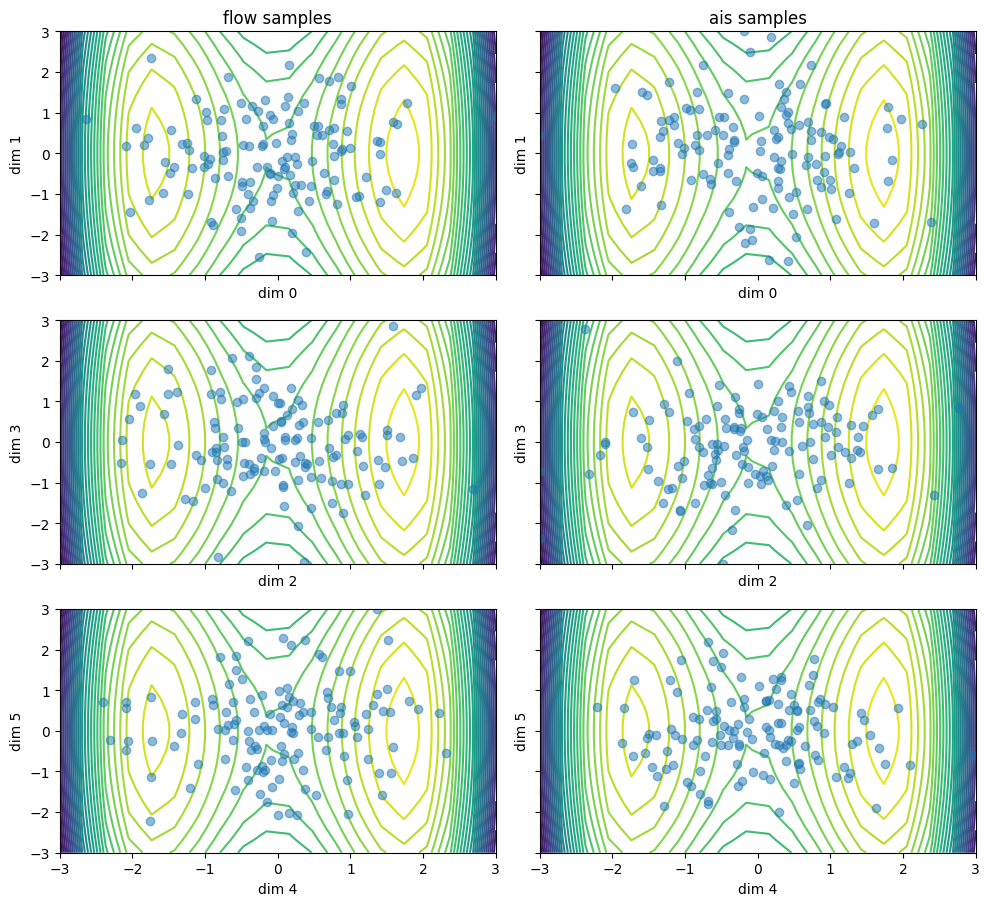

[<Figure size 1000x900 with 6 Axes>]

In [13]:
plot(fab_model) # Visualise model during initialisation.

In [14]:
# Setup trainer.
trainer = PrioritisedBufferTrainer(model=fab_model, optimizer=optimizer, 
                                   logger=logger, plot=plot,
                        buffer=buffer, n_batches_buffer_sampling=n_batches_buffer_sampling,
                     max_gradient_norm=max_gradient_norm, alpha=alpha)

## Train model

loss: 8.633368730022772, ess base: 0.008447495791065915,ess ais: 0.007834932903855627:   0%|                                                                                                           | 0/500 [00:00<?, ?it/s]

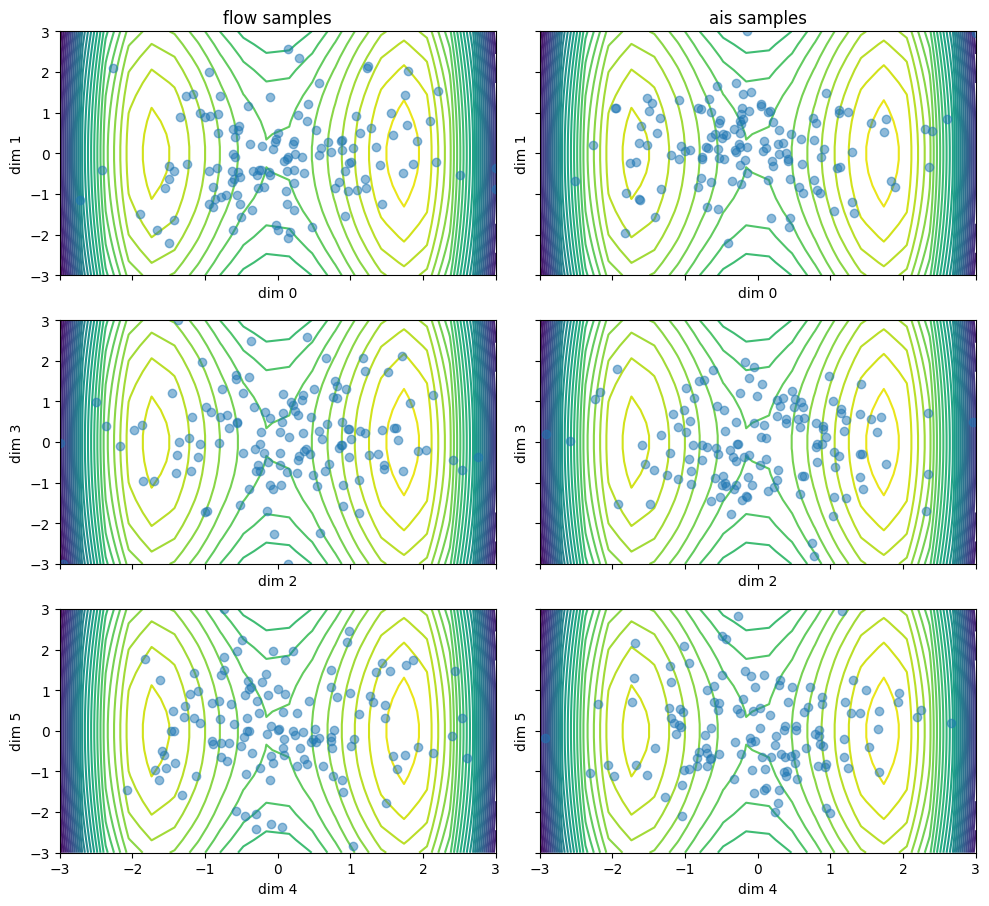

loss: 7.462452018200925, ess base: 0.12148688322715433,ess ais: 0.030352344311353887:  11%|██████████▉                                                                                        | 55/500 [00:14<01:36,  4.63it/s]

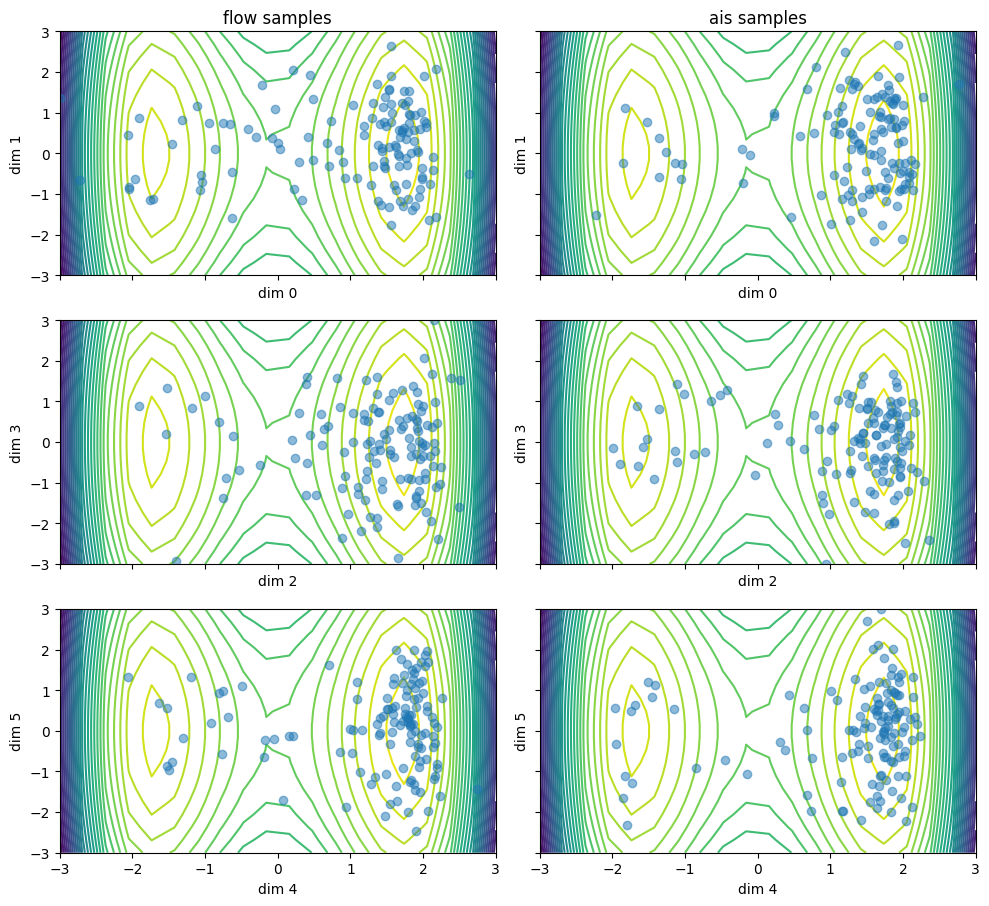

loss: 6.141143424056488, ess base: 0.3711454409311883,ess ais: 0.15050850501749283:  22%|██████████████████████                                                                              | 110/500 [00:29<01:40,  3.88it/s]

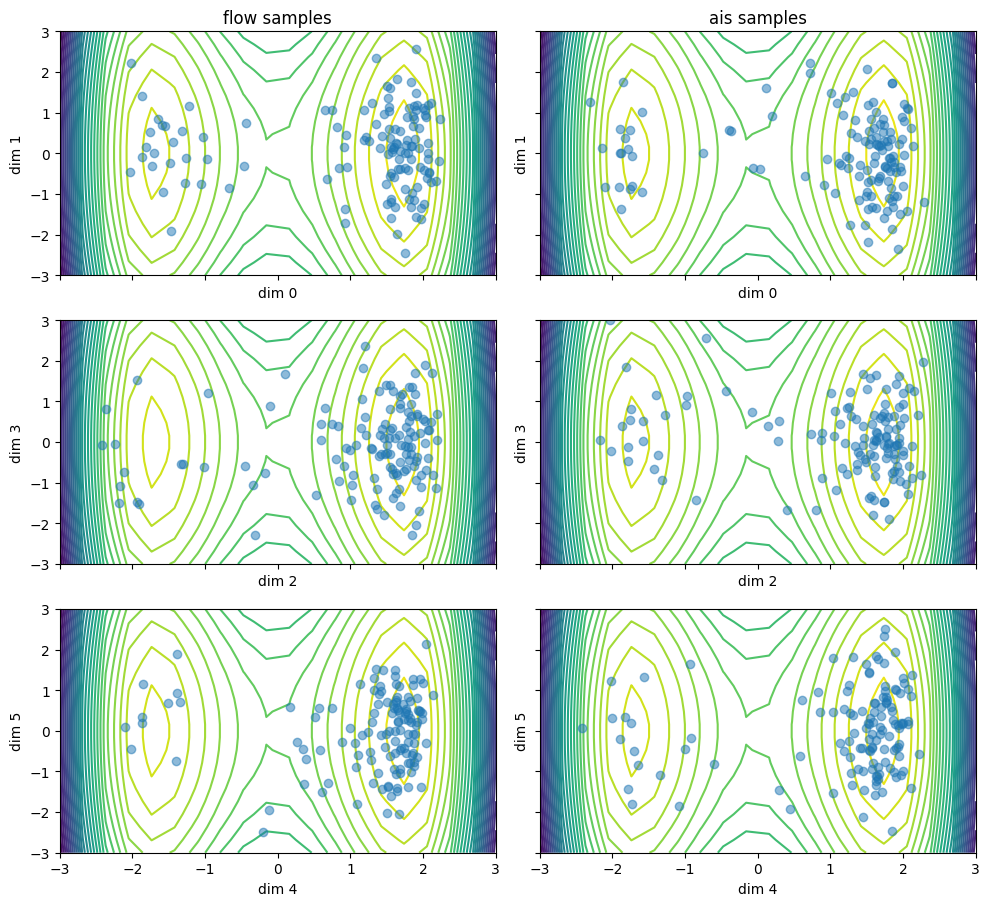

loss: 5.982430014470511, ess base: 0.4532184751750433,ess ais: 0.2096281971592022:  33%|█████████████████████████████████▌                                                                   | 166/500 [00:49<01:38,  3.41it/s]

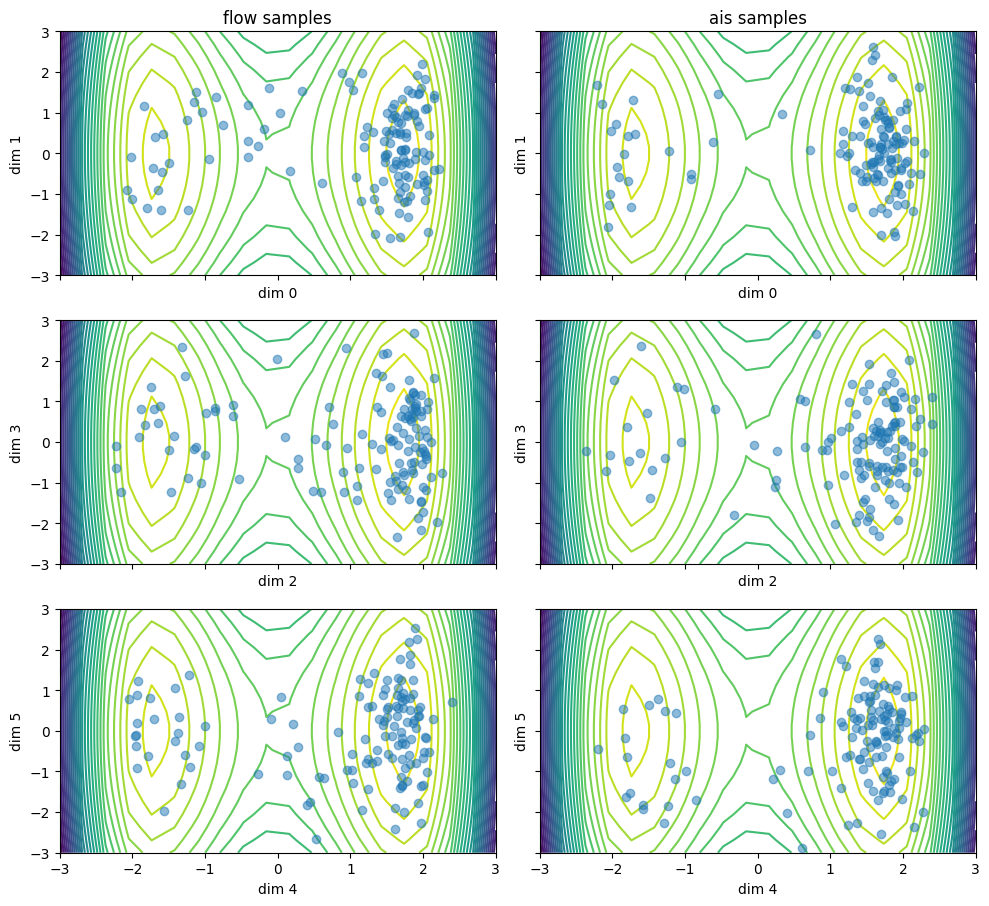

loss: 5.214960664735773, ess base: 0.5940311991326623,ess ais: 0.3879918662426578:  44%|████████████████████████████████████████████▋                                                        | 221/500 [01:11<01:31,  3.04it/s]

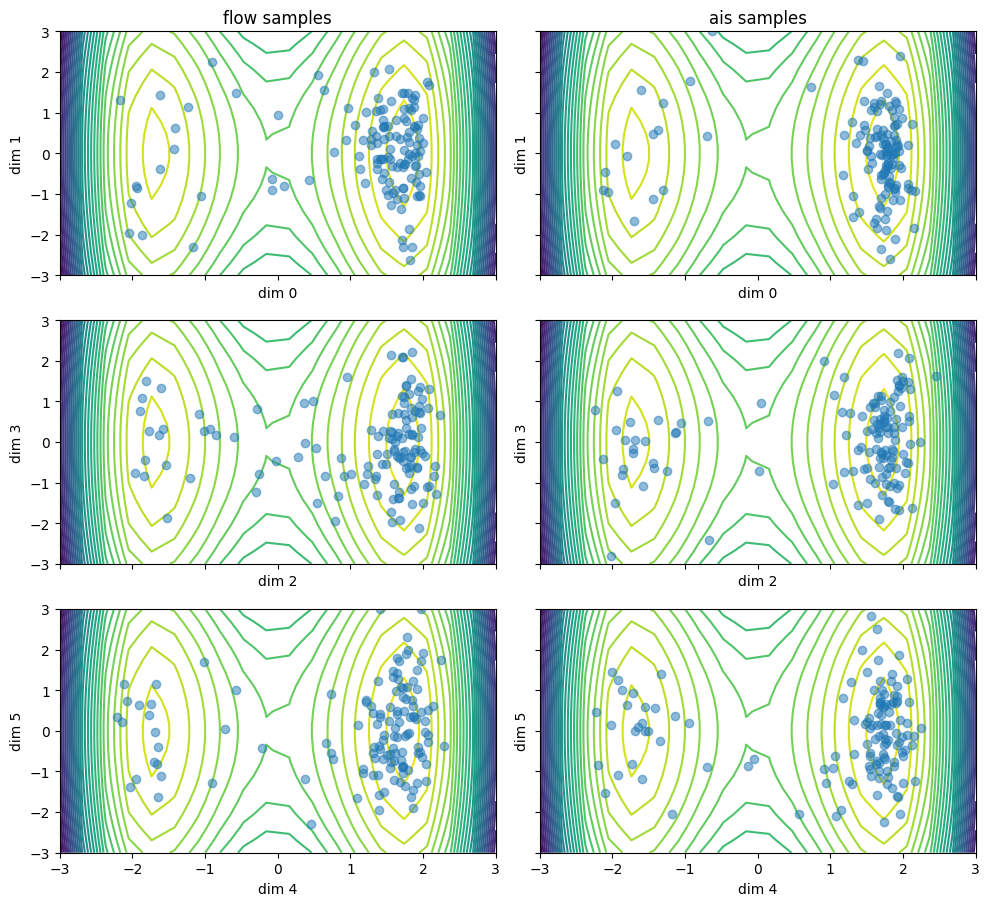

loss: 6.002157818864758, ess base: 0.617424628238824,ess ais: 0.31406526596046724:  55%|███████████████████████████████████████████████████████▉                                             | 277/500 [01:32<00:56,  3.94it/s]

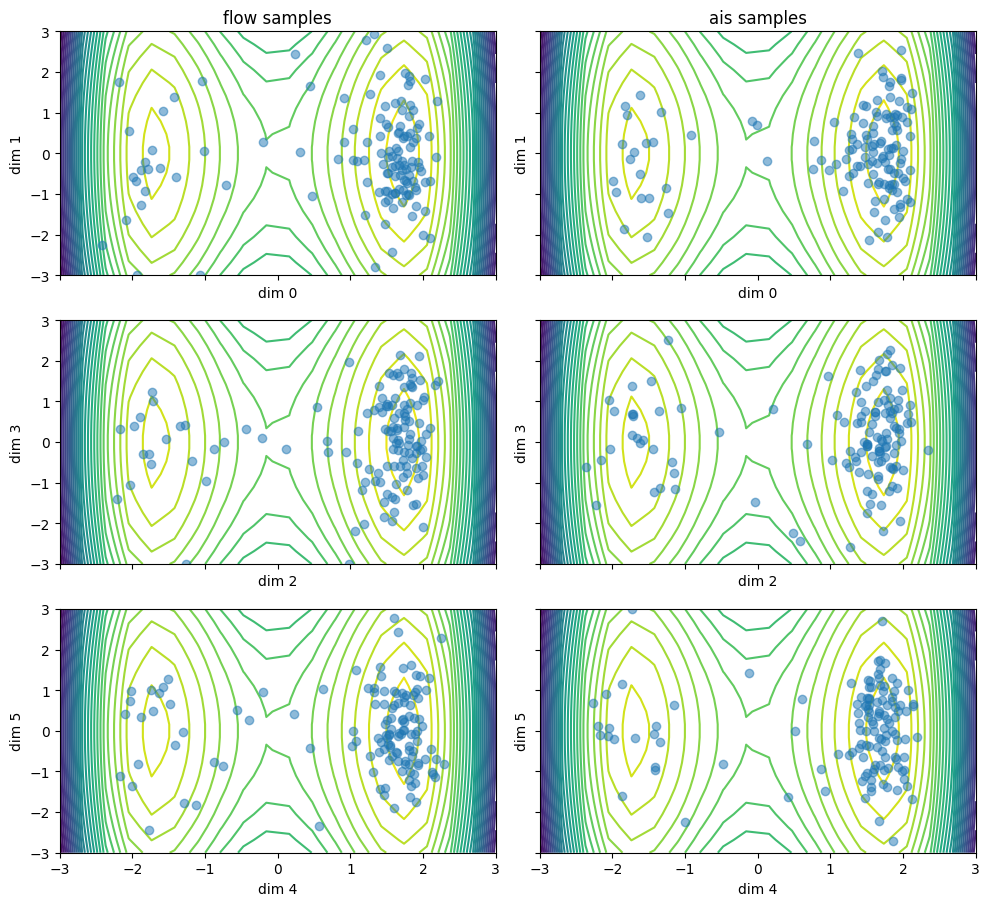

loss: 7.485120740155844, ess base: 0.6742823758988483,ess ais: 0.39876493442500116:  66%|██████████████████████████████████████████████████████████████████▍                                 | 332/500 [01:48<00:47,  3.55it/s]

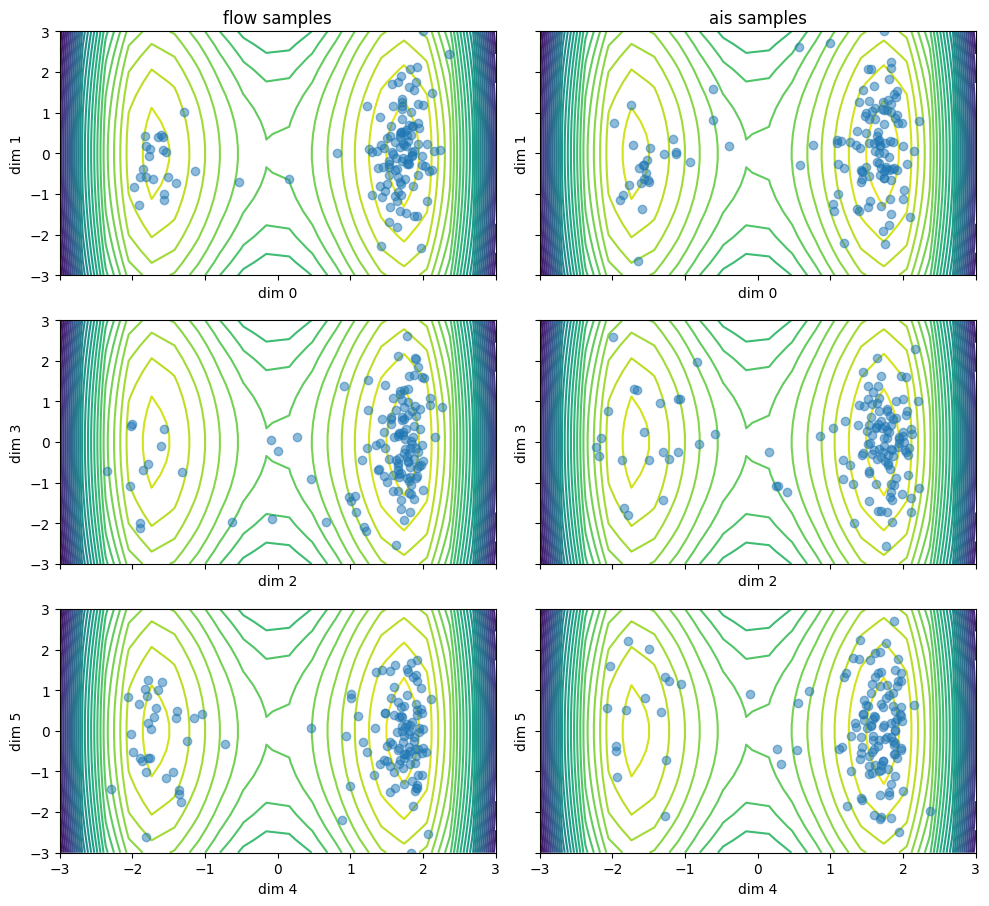

loss: 5.980023382362736, ess base: 0.6762083002376481,ess ais: 0.5043366603788645:  78%|██████████████████████████████████████████████████████████████████████████████▍                      | 388/500 [02:04<00:28,  3.87it/s]

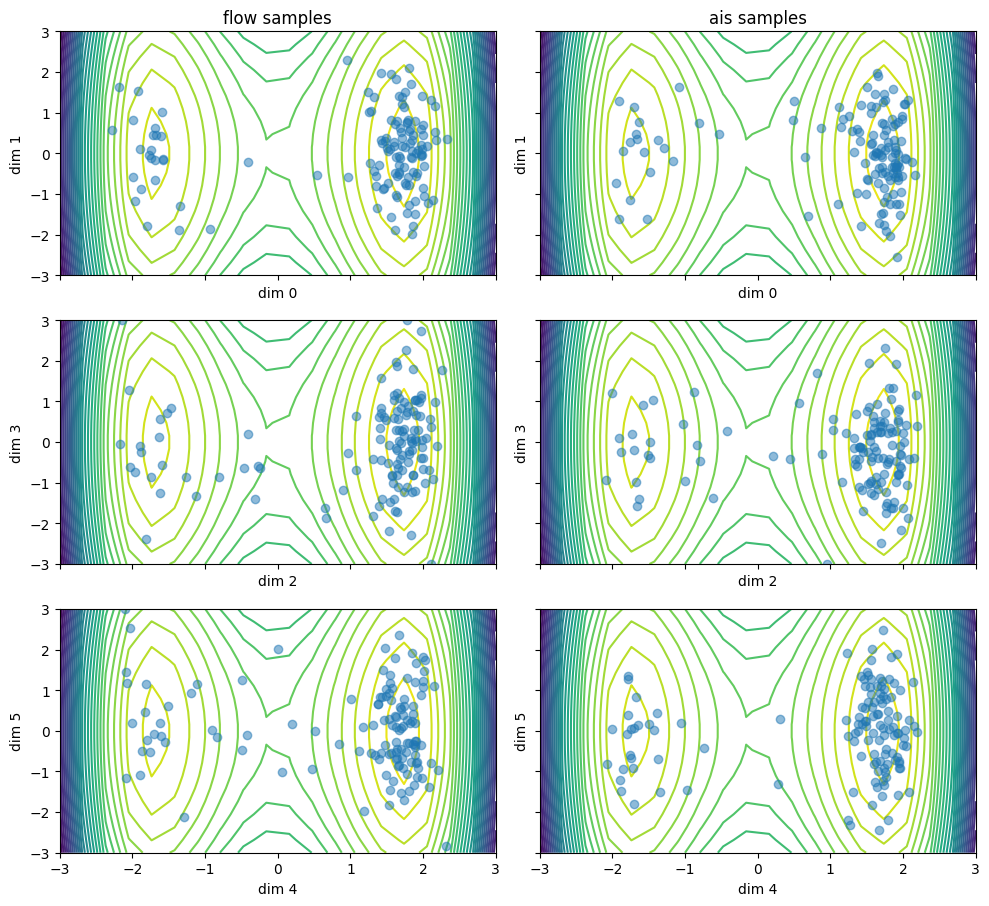

loss: 6.857412084961178, ess base: 0.5763929547915535,ess ais: 0.3179323434660286:  89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 443/500 [02:24<00:18,  3.14it/s]

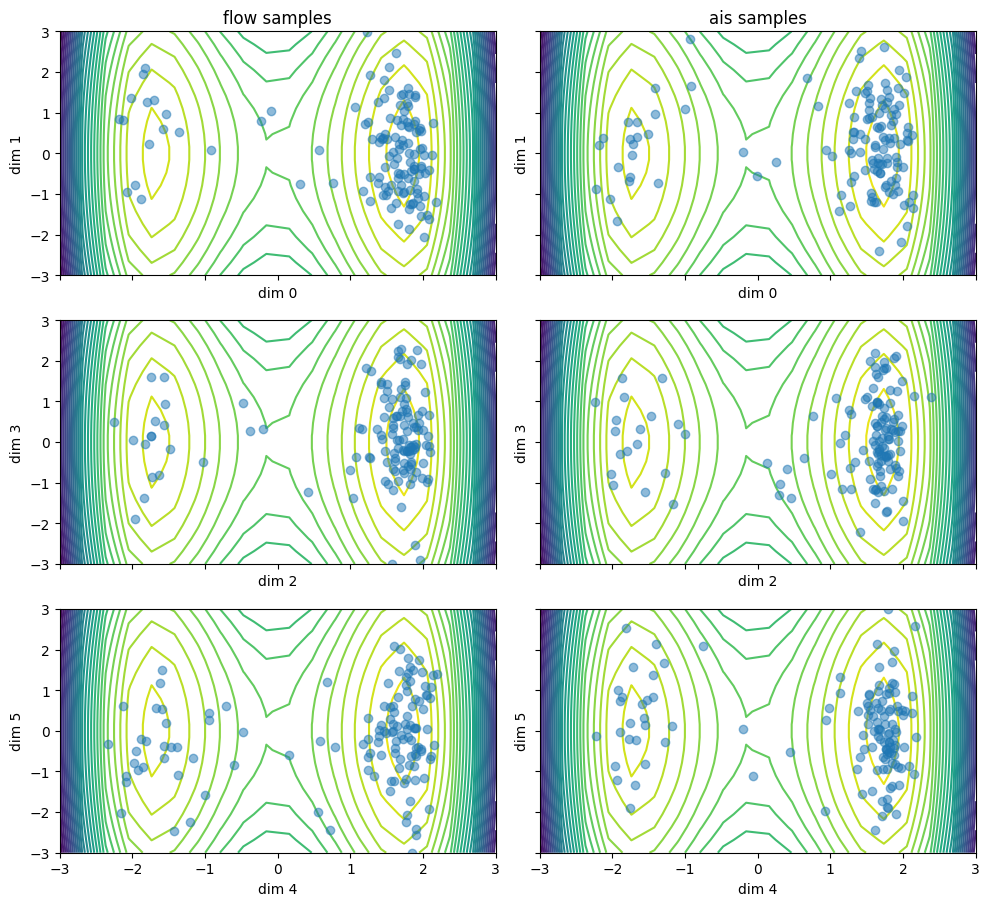

loss: 6.929196432985654, ess base: 0.6608255643525386,ess ais: 0.4447792449055003: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [02:45<00:00,  3.13it/s]

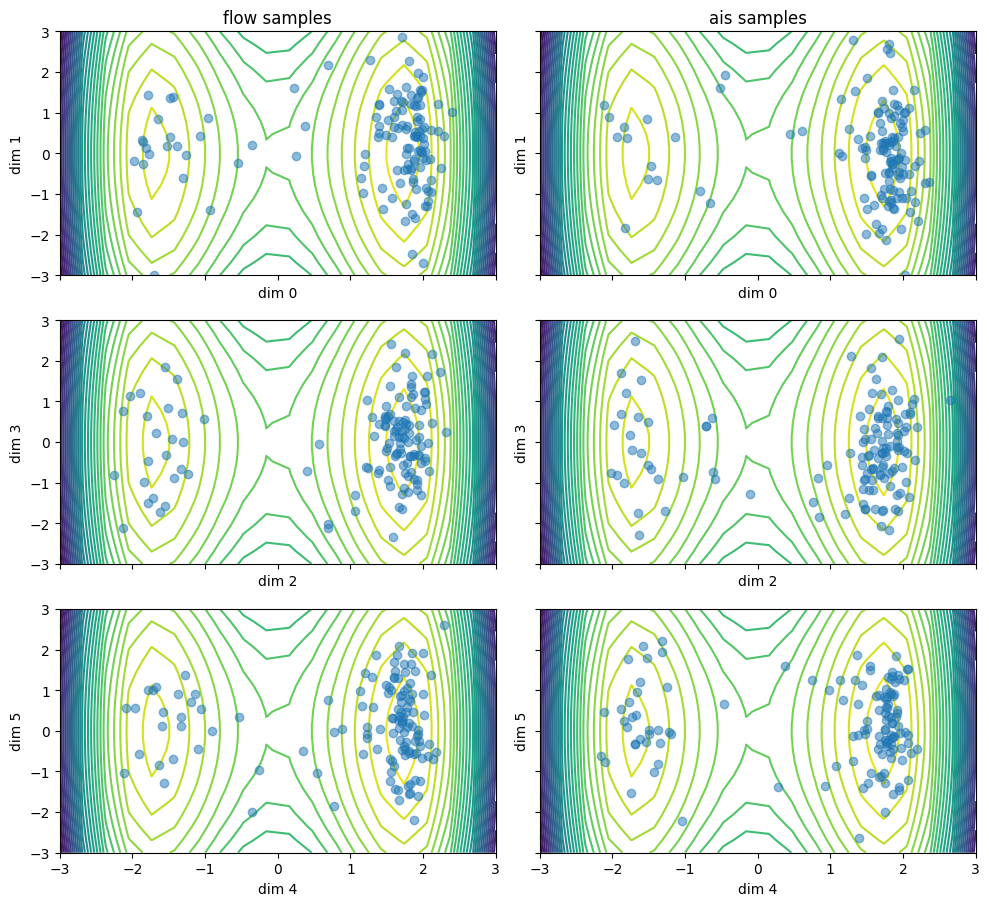

loss: 6.929196432985654, ess base: 0.6608255643525386,ess ais: 0.4447792449055003: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:50<00:00,  2.94it/s]

Timelimit not set


In [15]:
# Now run!
trainer.run(n_iterations=n_iterations, batch_size=batch_size, n_plot=n_plots, \
            n_eval=n_eval, eval_batch_size=eval_batch_size, save=False) # note that the progress bar during training prints ESS w.r.t p^2/q. 

In the below plot of samples from the flow vs the target contours, and with the test set log prob throughout training, we see that the flow covers the target distribution quite well. It may be trained further to obtain even better results. 

In [16]:
# "_eval" means metrics calculated with eval_batch_size, _p_target means metrics calculated with AIS targetting p, p2overq_target means calculated with AIS targeting p^2/q. 
# For example 'eval_ess_flow_p2overq_target' is the effective sample size of the flow w.r.t the target distribution p^2/q when sampling from AIS with p^2/q as the target.
logger.history.keys() 

dict_keys(['ess_base', 'ess_ais', 'log_Z', 'dist0_p_accept_0', 'epsilons_dist0_loop0', 'average_distance_dist0', 'loss', 'step', 'grad_norm', 'sampled_log_w_std', 'sampled_log_w_mean', 'w_adjust_mean', 'w_adjust_min', 'w_adjust_max', 'log_q_x_mean', 'eval_ess_flow_p_target', 'eval_ess_ais_p_target', 'test_set_modes_mean_log_prob_p_target', 'test_set_exact_mean_log_prob_p_target', 'MSE_log_Z_estimate_p_target', 'forward_kl_p_target', 'eval_batch_size_p_target', 'eval_ess_flow_min_var_target', 'eval_ess_ais_min_var_target', 'test_set_modes_mean_log_prob_min_var_target', 'test_set_exact_mean_log_prob_min_var_target', 'MSE_log_Z_estimate_min_var_target', 'forward_kl_min_var_target', 'eval_batch_size_min_var_target'])

Text(0.5, 0, 'training iteration')

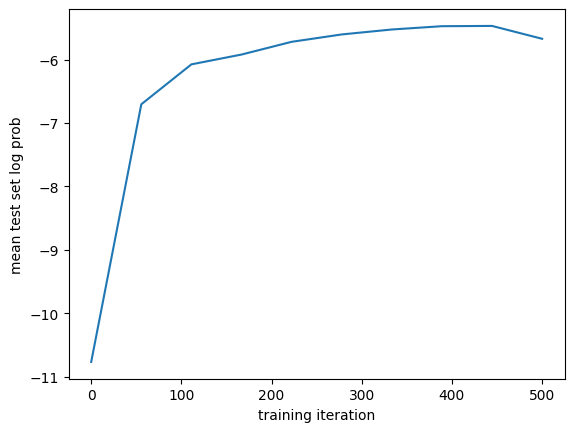

In [17]:
# Test set probability using samples from the target distribution.
eval_iters = np.linspace(0, n_iterations, n_eval)
plt.plot(eval_iters, logger.history['flow_test_set_exact_mean_log_prob_p_target'])
plt.ylabel("mean test set log prob")
plt.xlabel("training iteration")

Text(0.5, 0, 'training iteration')

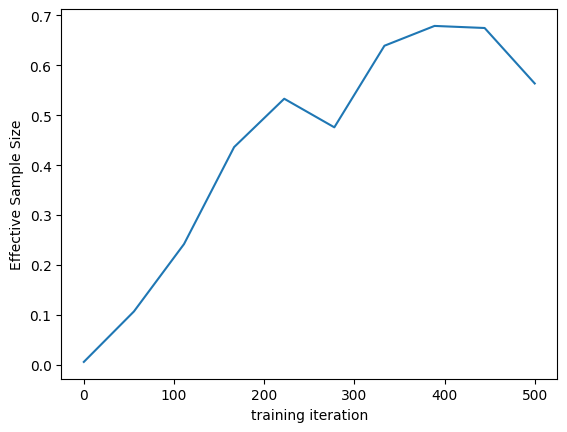

In [18]:
# Effective sample size
eval_iters = np.linspace(0, n_iterations, n_eval)
plt.plot(eval_iters, logger.history['eval_ess_flow_p_target'], label="flow")
plt.ylabel("Effective Sample Size")
plt.xlabel("training iteration")

Text(0.5, 0, 'training iteration')

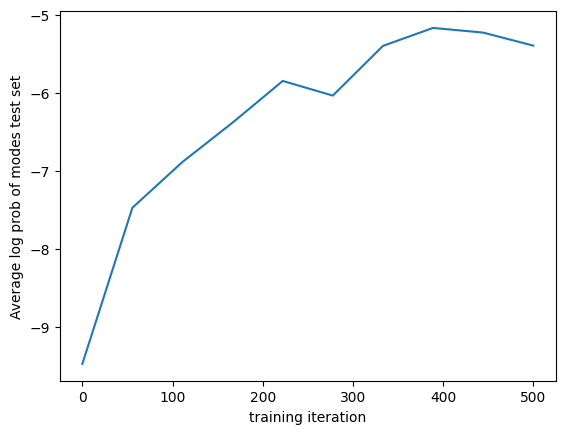

In [19]:
# Probability of test set containing a point on each mode
eval_iters = np.linspace(0, n_iterations, n_eval)
plt.plot(eval_iters, logger.history['flow_test_set_modes_mean_log_prob_p_target'])
plt.ylabel("Average log prob of modes test set")
plt.xlabel("training iteration")

Text(0.5, 0, 'training iteration')

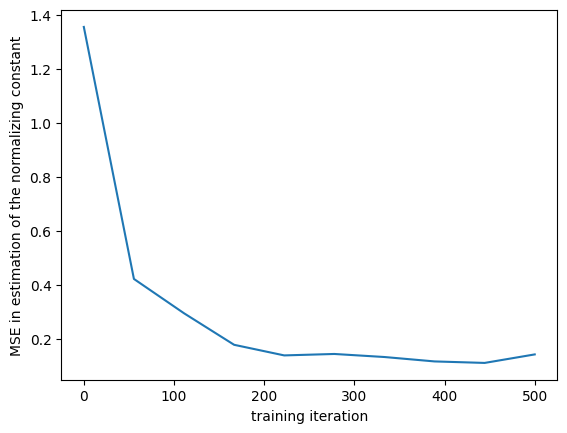

In [20]:
plt.plot(eval_iters, logger.history['flow_MSE_log_Z_estimate_p_target'], label="flow")
plt.plot(eval_iters, logger.history['flow_MSE_log_Z_estimate_p_target'], label="ais")
plt.ylabel("MSE in estimation of the normalizing constant")
plt.legend()
plt.xlabel("training iteration")

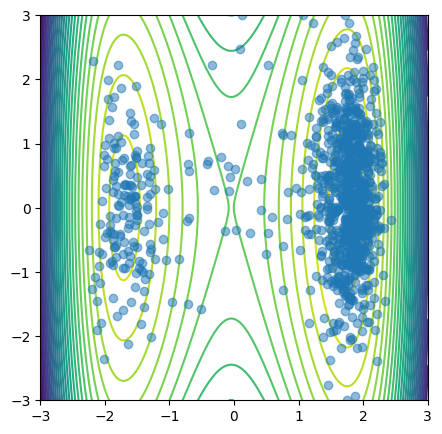

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
target.to("cpu")
plot_contours(target.log_prob_2D, bounds=plotting_bounds, ax=axs, n_contour_levels=40, grid_width_n_points=200)
if torch.cuda.is_available():
    target.to("cuda")

n_samples = 1000
samples_flow = fab_model.flow.sample((n_samples,)).detach()
plot_marginal_pair(samples_flow, ax=axs, bounds=plotting_bounds)

# Training a flow by reverse KL divergence minimisation.

In [ ]:
loss_type = "flow_reverse_kl" # can set to "target_foward_kl" for training by maximum likelihood of samples from the Many Well target.

In [ ]:
# Create flow using the same architecture.
flow = make_wrapped_normflow_realnvp(dim, n_flow_layers=n_flow_layers, 
                                 layer_nodes_per_dim=layer_nodes_per_dim,
                                act_norm = False)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
logger = ListLogger(save=False) # save training history

In [ ]:
# use GPU if available
if torch.cuda.is_available():
    flow.cuda()
    transition_operator.cuda()
    print(f"Running with GPU")
    target.to("cuda")

In [ ]:
n_iterations = int(4*(n_iterations)) # Training the flow by KL minimisation is cheaper per iteration, so we run it for more iterations.

In [ ]:
reverse_kld_model = FABModel(flow=flow,
                     target_distribution=target,
                     n_intermediate_distributions=n_intermediate_distributions,
                     transition_operator=transition_operator,
                     loss_type=loss_type,
                     alpha=None
                    )

In [ ]:
def plot_flow_reverse_kld(fab_model, n_samples = batch_size, dim=dim):
    n_rows = dim // 2
    fig, axs = plt.subplots(dim // 2, 1,  sharex=True, sharey=True, figsize=(5, n_rows*3))

    
    samples_flow = fab_model.flow.sample((n_samples,))

    for i in range(n_rows):
      plot_contours(target.log_prob_2D, bounds=plotting_bounds, ax=axs[i], n_contour_levels=40)

      # plot flow samples
      plot_marginal_pair(samples_flow, ax=axs[i], bounds=plotting_bounds, marginal_dims=(i*2,i*2+1))
      axs[i].set_xlabel(f"dim {i*2}")
      axs[i].set_ylabel(f"dim {i*2 + 1}")
      plt.tight_layout()
    plt.show()
    return [fig]

In [ ]:
trainer = Trainer(model=reverse_kld_model, optimizer=optimizer, logger=logger, plot=plot_flow_reverse_kld, max_gradient_norm=max_gradient_norm)

In [ ]:
# Now run!
trainer.run(n_iterations=n_iterations, batch_size=batch_size, n_plot=n_plots, \
            n_eval=n_eval, eval_batch_size=eval_batch_size, save=False)

We evaluate the flow on samples from the target distribution, we see that because the flow trained by kl divergence minimisation is missing modes, the flow places NaN log prob on samples from the target. 

In [ ]:
logger.history["test_set_exact_mean_log_prob"]

In [ ]:
eval_iters = np.linspace(0, n_iterations, n_eval)
plt.plot(eval_iters, logger.history["test_set_exact_mean_log_prob"])
plt.ylabel("mean test set log prob")
plt.xlabel("eval iteration")
plt.yscale("symlog")